In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy
import scipy.fftpack
import copy

## RemovePLI

In [2]:
def removePLI(x, fs, M, B, P, W, f_ac = None):
#    removePLI Power Line Interference Cancellation 
#    Author: Mauricio Cespedes Tenorio <mcespedes99@gmail.com>
#    This is the Python version of the code from: https://github.com/mrezak/removePLI 
#    which is an implementation of the proposed algorithm in,
#    M. R. Keshtkaran and Z. Yang, "A fast, robust algorithm for power line 
#    interference cancellation in neural recording," J. Neural Eng., vol. 11,
#    no. 2, p. 026017, Apr. 2014.
#    http://iopscience.iop.org/1741-2552/11/2/026017
#    http://arxiv.org/abs/1402.6862
#    Author of original MATLAB code: Mohammad Reza Keshtkaran <keshtkaran.github@gmail.com>

# 	Usage:
# 	s = removePLI(x, fs, M, B, P, W, f_ac)
#    x, input (contaminated) signal
# 	s, output (clean) signal
#    fs, sample rate in Hz
#    M, number of harmonics to remove
#    B, contains three elements [B0,Binf,Bst]: 
# 	- B0, Initial notch bandwidth of the frequency estimator
# 	- Binf, Asymptotic notch bandwidth of the frequency estimator
# 	- Bst, Rate of convergence to 95# of the asymptotic bandwidth Binf
#    P, contains three elements [P0,np.pinf,Pst]: 
# 	- P0, Initial settling time of the frequency estimator
# 	- np.pinf, Asymptotic settling time of the frequency estimator
# 	- Pst, Rate of convergence to 95# of the asymptotic settling time
# 	W, Settling time of the amplitude and phase estimator
#  	f_ac, Optional argument, the nominal AC frequency if known (50 Hz or 60 HZ)

# 	EXAMPLE:
# 		fs = 500
# 		n = 120*fs #2-min sequence	
# 		t = 2*np.pi*(1:n)/fs
# 		fline = 60 + randn #ramdom interference frequency
# 		s = filter(1,[1,-0.99],100*randn(1,n)) #1/f PSD
# 		p = 80*sin(fline*t+randn) + 50*sin(2*fline*t+randn)...
# 		  + 20*sin(3*fline*t+randn) # interference	
# 		x = s + p
#  		sbar = removePLI(x, fs, 3, [100,0.01,4], [0.1,2,5], 3)
#  		pwelch(s,[],[],[],fs) title('PSD of the original signal')
#  		figure pwelch(x(fs:end),[],[],[],fs) 
#        title('PSD of the contaminated signal')
#  		figure pwelch(sbar(fs:end),[],[],[],fs) 
#      title('PSD after interference cancellation')
    x_mean = np.mean(x)
    x = np.subtract(x, x_mean) #removing the mean
    N = len(x)
    s = np.zeros(N)

    # 3dB cutoff bandwidth
    alpha_f = (1-np.arctan(np.pi*B[0]/fs))/(1+np.arctan(np.pi*B[0]/fs))	#initial, \alpha_0
    alpha_inf = (1-np.tan(np.pi*B[1]/fs))/(1+np.tan(np.pi*B[1]/fs)) #asymptotic	
    alpha_st = np.exp(np.log(0.05)/(B[2]*fs+1))	#rate of change

    # frequency estimator's forgetting factors
    lambda_f = np.exp(np.log(0.05)/(P[0]*fs+1))	#initial
    lambda_inf = np.exp(np.log(0.05)/(P[1]*fs+1))	#asymptotic
    lambda_st = np.exp(np.log(0.05)/(P[2]*fs+1))	#rate of change
    # Smoothing parameter (cut-off freq set at 90 Hz)
    gmma = (1-np.tan(0.5*np.pi*min(90,fs/2)/fs))/(1+np.tan(0.5*np.pi*min(90,fs/2)/fs))

    # phase/amplitude estimator forgetting factor
    lambda_a = np.exp(np.log(0.05)/(W*fs+1))
    if type(lambda_a)!=list: lambda_a = lambda_a*np.ones(M)

    # initializing variables
    kappa_f = 0
    kappa_k = np.zeros(M+1)
    D=10
    C=5
    f_n1=0
    f_n2=0

    # -- Alternative initialization:
    #    kappa_f = cos(55*2*np.pi/fs)
    # --

    # initializing the first oscillator
    u_kp = 1*np.ones(M) #u_k
    u_k = 1*np.ones(M) #u'_k

    # initializing the RLS parameters
    r1 = 10*np.ones(M)
    r4 = 10*np.ones(M)
    a = np.zeros(M)
    b = np.zeros(M)


    # IIR Bandpass filtering:
    if(f_ac != None):     # if AC frequency is known
        if type(f_ac)==list and len(f_ac)==2:
            Fc1 = f_ac[0]  # First Cutoff Frequency
            Fc2 = f_ac[1]  # Second Cutoff Frequency               
        else:
            #Custom center frequency of pass band
            Fc1 = f_ac-2  # First Cutoff Frequency
            Fc2 = f_ac+2  # Second Cutoff Frequency
    else:  #if AC frequency is not known
        #Default 40--70 Hz pass band
        Fc1 = 40  # First Cutoff Frequency
        Fc2 = 70  # Second Cutoff Frequency
    

    ordr   = 4   # Order
    frange  = [Fc1, Fc2]
    nyquist = fs/2 #
    fkernB,fkernA = signal.butter(4,np.array(frange)/nyquist,btype='bandpass')
    x_f =  signal.filtfilt(fkernB,fkernA,x)
    x_f = np.concatenate(([0], np.diff(x_f)))		#First Difference
    
    # h  = fdesign.bandpass('N,F3dB1,F3dB2', ordr, Fc1, Fc2, fs)
    # Hd = design(h, 'butter')
    # x_f = filter(Hd,x)	#Bandpass Filtering
    # x_f = [0 diff(x_f)]		#First Difference

    #--------- Start of data processing:
    for n in np.arange(1,N):
        # print(kappa_f)
        # Lattice Filter
        f_n = x_f[n] + kappa_f*(1+alpha_f)*f_n1 - alpha_f*f_n2

        # Frequency Estimation
        C = lambda_f*C+(1-lambda_f)*f_n1*(f_n+f_n2)
        D = lambda_f*D+(1-lambda_f)*2*f_n1**2
        kappa_t=C/D
        if kappa_t <-1: kappa_t=-1
        if kappa_t > 1: kappa_t= 1
        kappa_f = gmma*kappa_f + (1-gmma)*kappa_t
        # print(kappa_f)
        # Updating lattice states
        f_n2=f_n1
        f_n1=f_n  

        # Bandwidth and Forgetting Factor Updates
        alpha_f = alpha_st*alpha_f + (1-alpha_st)*alpha_inf
        lambda_f = lambda_st*lambda_f + (1-lambda_st)*lambda_inf

        # Discrete-Time Oscillators
        kappa_k[1] = kappa_f
        kappa_k[0] = 1

        e=x[n]
        for k in np.arange(0,M): #for each harmonic do:
            # calculating Cos(kw) for k=1,2...
            if(k+2<=M):
                kappa_k[k+2] = 2*kappa_f*kappa_k[k+1] - kappa_k[k];
            kappa = kappa_k[k+1]
            # print(kappa)
            # Oscillator
            tmp = kappa*(u_kp[k]+u_k[k])
            tmp2 =u_kp[k]
            u_kp[k] = tmp - u_k[k]
            u_k[k] = tmp + tmp2

            # Gain Control
            G = 1.5 - (u_kp[k]**2 - (kappa-1)/(kappa+1)*u_k[k]**2)
            if G<=0: G=1
            u_kp[k] = G * u_kp[k]
            u_k[k] = G * u_k[k]

            # Phase/Amplitude Adaptation
            sincmp = a[k]*u_k[k] + b[k]*u_kp[k]
            e = e - sincmp
            # Simplified RLS
            r1[k] = lambda_a[k]*r1[k] + u_k[k]**2
            r4[k] = lambda_a[k]*r4[k] + u_kp[k]**2
            a[k] = a[k] + u_k[k]*e/r1[k]
            b[k] = b[k]  + u_kp[k]*e/r4[k] 
        s[n]=e
        # return None
    print(kappa_k)
    return s

## Zapline

In [3]:
import numpy as np
import scipy.signal
def square_filt(x,T,nIterations=1):
  #y=nt_smooth(x,T,nIterations,nodelayflag) - smooth by convolution with square window
  #
  #  y: smoothed data
  # 
  #  x: data to smooth
  #  T: samples, size of window (can be fractionary)
  #  nIterations: number of iterations of smoothing operation (large --> gaussian kernel)
  #

  integ=int(np.floor(T))
  frac=T-integ

  # if integ>=size(x,1);
  #     x=repmat(mean(x),[size(x,1),1,1,1]);
  #     return;
  # end

  # remove onset step
  mn = np.mean(x[0:integ+1,:], axis=0)
  x= x - mn

  if nIterations==1 and frac==0:
      # faster
      x=np.cumsum(x);
      x[T:,:]=x[T:,:]-x[0:-T,:]
      x=x/T
  else:
      # filter kernel
      B = np.concatenate((np.ones(integ), [frac]))/T
      for k in np.arange(1,nIterations):
          B=np.convolve(B, B)
          print('aqui')
      x=scipy.signal.filtfilt(B, 1, x, axis=0) #lfilter

  # restore DC
  x=x+mn
  return x

In [4]:
# Possible alternative to square filter
import numpy as np
import scipy.signal
import scipy.fftpack
def square_notch_filt(x, fline, srate, nHarmonics, plotting=False):
  #y=nt_smooth(x,T,nIterations,nodelayflag) - smooth by convolution with square window
  #
  #  y: smoothed data
  # 
  #  x: data to smooth
  #  T: samples, size of window (can be fractionary) 
  #  nIterations: number of iterations of smoothing operation (large --> gaussian kernel)
  #

  # if integ>=size(x,1);
  #     x=repmat(mean(x),[size(x,1),1,1,1]);
  #     return;
  # end
  fline = fline*srate
  # remove onset step
  mn = np.mean(x, axis=0)
  x= x - mn
  # Apply filter
  lower_trans = .1
  upper_trans = .1
  norder = 24
  filtorder = norder*np.round(srate/55)+1
  for n in np.arange(1, nHarmonics+1):
    if n>1:
      filtorder = int(filtorder/(n*0.6)) # Change 0.6 to a parameter
      if filtorder % 2 == 0:
        filtorder += 1
    f_harmonic = n*fline
    lower_bnd = f_harmonic-5
    upper_bnd = f_harmonic+5
    # filter kernel
    filter_shape = [ 1,1,0,0,1,1 ]
    filter_freqs = [ 0, lower_bnd*(1-lower_trans), lower_bnd, upper_bnd, \
                    upper_bnd+upper_bnd*upper_trans, srate/2 ]
    filter_kern = scipy.signal.firls(filtorder,filter_freqs,filter_shape,fs=srate)
    # Apply filter:
    x = scipy.signal.filtfilt(filter_kern,1,x, axis=0)
    if plotting:
      fig,ax2 = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
      # Power spectrum
      hz = np.linspace(0,srate/2,int(np.floor(len(filter_kern)/2)+1))
      filterpow = np.abs(scipy.fftpack.fft(filter_kern))**2
      ax2.plot(hz,filterpow[:len(hz)], 'ks-')
      plt.plot(filter_freqs,filter_shape,'ro-')
      ax2.set_xlim([0,srate/2])
      ax2.set_xlabel('Frequency (Hz)')
      ax2.set_ylabel('Filter gain')
      ax2.set_title('Frequency response')
      plt.show()
  # Plot to check
  # if plotting: # Needs fix

    # Filter kernel
    # fig,[ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    # ax1.plot(filter_kern)
    # ax1.set_xlabel('Time points')
    # ax1.set_title('Filter kernel (firls)')
    # # Power spectrum
    # hz = np.linspace(0,srate/2,int(np.floor(len(filter_kern)/2)+1))
    # filterpow = np.abs(scipy.fftpack.fft(filter_kern))**2
    # ax2.plot(hz,filterpow[:len(hz)],'ks-')
    # ax2.set_xlim([0,srate/2])
    # ax2.set_xlabel('Frequency (Hz)')
    # ax2.set_ylabel('Filter gain')
    # ax2.set_title('Frequency response')
    # plt.show()
  # restore DC
  x=x+mn
  return x

In [5]:
import scipy.fftpack
def bias_fft(x,freq,nfft):
  #[c0,c1]=nt_bias_fft(x,freq,nfft) - covariance with and w/o filter bias
  #
  # x: data 
  # freq: row vector of normalized frequencies to keep (wrt sr)
  # nfft: fft size
  #
  # The filter has zeros at all frequencies except those immediately inferior
  # or superior to values in vector freq.
  # 
  # If freq has two rows, keep frequencies between corresponding values on
  # first and second row.
  #
  # NoiseTools

  if max(freq)>0.5: 
    raise Exception('frequencies should be <= 0.5')
  if nfft > x.shape[0]: 
    raise Exception('nfft too large')

  # Here the filter is built in the freq domain, which has a reflection
  # Left half of the filter
  filt=np.zeros(int(np.floor(nfft/2)+1))
  for k in np.arange(0,len(freq)):
      idx=int(freq[k]*nfft+0.5)
      filt[idx]=1

  filt=np.concatenate((filt,np.flipud(filt[0:-1])))

  ## now for convolution
  n = x.shape[0]
  k = len(filt)
  nConv = n + k -1
  half_kern = int( np.floor(k/2) )
  filt = scipy.fftpack.fft(scipy.fftpack.ifft(filt),nConv)

  # FFTs
  dataX = scipy.fftpack.fft(x, nConv, axis=0)

  # IFFT
  x_filt = np.multiply(dataX, filt.reshape(len(filt),1))
  x_filt = np.real( scipy.fftpack.ifft( x_filt , axis=0))
  x_filt = x_filt[half_kern:-half_kern,:]
  
  c0 = np.cov(x.T)
  c1 = np.cov(x_filt.T)

  # return x_filt
  return c0, c1

In [7]:
from numpy.linalg import eig
def eigen(A):
  # Calculates ordered real part of eigenvalues and eigenvectors
  [eigvals,eigvecs]=eig(A)
  eigvecs = np.real(eigvecs)
  eigvals = np.real(eigvals)
  idx = np.flipud(np.argsort(eigvals))
  eigvals = np.flipud(np.sort(eigvals))
  eigvecs = eigvecs[:,idx]
  return eigvals, eigvecs

In [6]:
import numpy as np
def dss(c0,c1):
  #[todss,pwr1,pwr2]=nt_dss0(c0,c1,keep1,keep2) - dss from covariance
  #
  # todss: matrix to convert data to normalized DSS components
  # pwr0: power per component (baseline)
  # pwr1: power per component (biased)
  #
  # c0: baseline covariance
  # c1: biased covariance
  # keep1: number of PCs to retain (default: all)
  # keep2: ignore PCs smaller than keep2 (default: 10.^-9)
  #

  if c0.shape != c1.shape: 
    raise Exception('C0 and C1 should have same size')
  if c0.shape[0] != c0.shape[1]:
    raise Exception('C0 should be square')

  # if any(find(isnan(c0)))
  #     error('NaN in c0');
  # end
  # if any(find(isnan(c1)))
  #     error('NaN in c1');
  # end
  # if any(find(isinf(c0)))
  #     error('INF in c0');
  # end
  # if any(find(isinf(c1)))
  #     error('INF in c1');
  # end
  # Eig vals and vecs from the unbiased covariance
  [eigvals0,eigvecs0] = eigen(c0)
  eigvals0 = np.abs(eigvals0)

  # apply PCA and whitening to the biased covariance
  N = np.diag(np.sqrt(1/(eigvals0)))    
  c2 = np.transpose(N) @ np.transpose(eigvecs0) @ c1 @ eigvecs0 @ N

  # matrix to convert PCA-whitened data to DSS
  [eigvals1,eigvecs1]= eigen(c2)

  # DSS matrix (raw data to normalized DSS)
  todss = eigvecs0*N*eigvecs1
  N2 = np.diag(np.transpose(todss) @ c0 @ todss)
  todss=todss*np.diag(1/np.sqrt(N2)) # adjust so that components are normalized
  return todss

In [8]:
def crosscov(x,y):
  c = np.transpose(x) @ y
  return c

In [9]:
def denoise_PCA(x, ref):
  mnx = np.mean(x, axis=0)
  x = x - mnx
  

  mnref = np.mean(ref)
  ref = ref - mnref

  # print(len(x))
  cref = ref.T @ ref
  cref = cref / len(x)

  # The crosscov matrix would be just a way of measuring how each channel of x
  # related to the reference signal
  cxref = crosscov(x,ref)
  cxref = cxref/len(x)


  # regression matrix of x on ref
  # PCA of regressor
  if cref.size>1:
    print('lolo')
    [eigenvalues, eigvecs]=eigen(cref)
    # cross-covariance between data and regressor PCs
    cxref = np.transpose(cxref)
    r = np.transpose(eigvecs) @ cxref
    eigenvalues = np.reshape(eigenvalues, (len(eigenvalues),1))
    r = np.multiply(r, 1/eigenvalues)
    r = eigvecs @ r
  else:
    [eigenvalues, eigvecs] = [1, 1]
    # cross-covariance between data and regressor PCs
    cxref = np.transpose(cxref)
    # print(cxref)
    r = cxref

  # TSPCA
  # Then here r is just how each channel from x (which represents the original noise) variates 
  # compare to ref (which is just a mx1 signal that represents the best the PL
  # noise accross channels). So it just means the weights of ref to 'reconstruct'
  # each channel from x. The result of ref*r would be constructing a signal per channel
  # that represents the best x based only in ref, which is the PL noise!!
  z = ref @ r
  # z = z/2
  y = x-z
  mny = np.mean(y, axis=0)
  y = y-mny
  return y

In [10]:
import warnings
import numpy as np
from sklearn.decomposition import PCA
def zapline(x, fline, srate, nremove=1, p={}, filt=2):
  #[y,yy]=nt_zapline(x,fline,nremove,p,plotflag) - remove power line artifact
  #
  #  y: denoised data
  #  yy: artifact
  #
  #  x: data
  #  fline: line frequency (normalized to sr)
  #  nremove: number of components to remove [default: 1]
  #  p: additional parameters:
  #    p.nfft: size of FFT [default:1024]
  #    p.nkeep: number of components to keep in DSS [default: all]
  #    p.niterations: number of iterations for smoothing filter
  #    p.fig1: figure to use for DSS score [default: 100]
  #    p.fig2: figure to use for results [default: 101]
  #  plotflag: plot
  #
  #Examples:
  #  nt_zapline(x,60/1000) 
  #    apply to x, assuming line frequency=60Hz and sampling rate=1000Hz, plot results
  #  nt_zapline(x,60/1000,4)
  #    same, removing 4 line-dominated components 
  #  p=[];p.nkeep=30; nt_zapline(x,60/1000,4,p);
  #    same, truncating PCs beyond the 30th to avoid overfitting
  #  [y,yy]=nt_zapline(x,60/1000)
  #    return cleaned data in y, noise in yy, don't plot
  #
  if p=={}:
    p['nfft'] = 1024
    p['nkeep'] = []
    p['niterations'] = 1

  # Handling arguments
  if x.size == 0:
    raise Exception("x data cannot be an empty array")
  # Assuming a shape nxm for x:
  if nremove>=x.shape[0]:
    raise Exception("Number of components cannot be larger than lenght of each signal")
  if fline>1/2:
    raise Exception('fline should be less than Nyquist')
  if x.shape[0]<p['nfft']:
    warnings.warn(f'reducing nfft to {str(x.shape[0])}')
    p['nfft']=2*np.floor(x.shape[0]/2)

  if filt==1:
    xx=square_filt(x,1/fline,p['niterations']) # cancels line_frequency and harmonics, light lowpass
  elif filt==2:
    xx=square_notch_filt(x,fline, srate, 3)
  if p['nkeep']==[]: 
    try:
      p['nkeep']=x.shape[1]
    except:
      p['nkeep'] = 1
  # reduce dimensionality to avoid overfitting
  x_rem = x-xx
  c = np.cov(x_rem.T)
  [eigenvalues, eigvecs]=eigen(c)
  # In python, each column of eigvecs represent an eigenvector. So you have to 
  # multiple x * eigvecs. Easy way to say it, a chunk version of eigvecs could
  # be nxk so the only way to multiply it is x*eigvecs
  # This just rotates the data according to the principal components
  xxxx = (x_rem) @ (eigvecs) 
  
  print('caca')
  # DSS to isolate line components from residual:
  nHarmonics=np.floor((1/2)/fline);
  [c0,c1]=bias_fft(xxxx, fline*np.arange(1,nHarmonics+1), p['nfft']);
  # print('c0')
  # print(c0)
  # print('c1')
  # print(c1)
  print('2')
  todss = dss(c0,c1);
  print('3')
  # This would be the projection of the noise to the main component of the biased
  # noise, which should represent the line noise.
  xxxx= xxxx @ todss[:,0:nremove] # line-dominated components. 
  # return xxxx
  # Denoise
  xxx =denoise_PCA(x-xx,xxxx); # project them out
  del xxxx

  # reconstruct clean signal
  y=xx+xxx
  del xx
  # del xxx
  yy=x-y

  return y

## Cleanline

In [11]:
from multiprocessing.pool import Pool
from functools import partial
def cleanline(EEG, srate, processes=None, channels = [], linefreq = [60], p=0.01, bandwidth = 2, taperHalfBW = 1, taperWinSize=4, taperWinStep = 1, tau=100, padding = 2):
  fPassBand = [0, srate/2]
  maximumIterations = 10
  # Add harmonics:
  if len(linefreq) == 1:
    lf = linefreq[0]
    for i in range(2,4):
      if i*lf < srate/2:
        linefreq.append(i*lf)
    del lf
  print(linefreq)
  # Set channels if not set
  if len(channels)==0:
    sz = EEG.shape
    channels = np.arange(sz[1]) # EEG should be samples x number channels
  
  # Set up multi-taper parameters
  taperTemplate = [taperHalfBW, taperWinSize, 1]
  Nwin = round(srate*taperWinSize) # number of samples in window
  # Window cannot be longer than time points
  if Nwin>EEG.shape[0]:
    Nwin = EEG.shape[0]
  tapers = checkTapers(taperTemplate, Nwin, srate)

  # Perform the calculation for each channel separately
  channels = np.sort(channels)
  data = np.zeros(EEG.shape)
  with Pool(processes=processes) as pool:
      data_list = pool.map(partial(removeLinesMovingWindow, data=EEG, fPassBand=fPassBand, srate=srate,
                               bandwidth=bandwidth, linefreq=linefreq, maximumIterations=maximumIterations,
                               p=p, padding=padding, tapers=tapers, taperWinSize=taperWinSize, 
                               taperWinStep=taperWinStep, tau=tau), 
                      channels)
  for ch in np.arange(len(data_list)):
    data[:,ch] = data_list[ch]
  # for ch in channels: # Change to multiprocessing!
  #     print(ch)
  #     data[:, ch] = removeLinesMovingWindow(EEG[:, ch], fPassBand, srate, bandwidth, linefreq, maximumIterations, p, padding, tapers, taperWinSize, taperWinStep, tau)
  
  return data
  

In [12]:
import numpy as np
import scipy.signal as ss
def checkTapers(tapers, N, Fs):
  # Helper function to calculate tapers and, if precalculated tapers are supplied, 
  # to check that they (the precalculated tapers) the same length in time as
  # the time series being studied. The length of the time series is specified
  # as the second input argument N. Thus if precalculated tapers have
  # dimensions [N1 K], we require that N1=N.
  # Usage: tapers=dpsschk(tapers,N,Fs)
  # Inputs:
  # tapers        (tapers in the form of: 
  #                                   (i) precalculated tapers or,
  #                                   (ii) [NW K] - time-bandwidth product, number of tapers) 
  #
  # N             (number of samples)
  # Fs            (sampling frequency - this is required for nomalization of
  #                                     tapers: we need tapers to be such
  #                                     that integral of the square of each taper equals 1
  #                                     dpss computes tapers such that the
  #                                     SUM of squares equals 1 - so we need
  #                                     to multiply the dpss computed tapers
  #                                     by sqrt(Fs) to get the right
  #                                     normalization)
  # Outputs: 
  # tapers        (calculated or precalculated tapers)
  # eigs          (eigenvalues) 
  if  len(tapers) == 3:   # Fix taper specification
      # Compute timebandwidth product (half BW * N)
      TW =  tapers[0] * tapers[1]
      # Compute number of tapers
      K  = int(np.floor(2*TW -  tapers[2]))
      tapers = [TW,  K]
  sz = len(tapers)
  if sz == 2:
      tmp, eigs = ss.windows.dpss(N, tapers[0], tapers[1], return_ratios=True)
      # Ideally the tapers shouldn't be multiplied by the sqrt(Fs) here as this is only required for
      # the removeLinesMovingWindow function
      tapers = tmp*np.sqrt(Fs)
      # print(tapers.shape)
  return  np.array(tapers).T

In [13]:
def removeLinesMovingWindow(channel, data, fPassBand, srate, bandwidth, linefreq, maximumIterations, p, padding, tapers, taperWinSize, taperWinStep, tau):
    # Removes significant sine waves from (continuous) data using overlapping windows.
    #
    # Usage:
    #    data = removeLinesMovingWindow(data, lineNoise)
    #
    # Parameters
    #       data        data in [N,1] (a single time column vector)
    #       lineNoise   structure with various parameters set
    #       fPassBand       Frequency band used 
    #       srate           Sampling frequency 
    #       bandwidth  +/- bandwidth centered on each f0 to scan for significant
    #                       lines (TM)
    #       linefreq Line frequencies to be removed 
    #       maximumIterations   Maximum times to iterate removal 
    #       p               Significance level cutoff 
    #       padding             FFT padding factor 
    #       tapers          Precomputed tapers from dpss
    #       taperWinSize Taper sliding window lenght (seconds) 
    #       taperWinStep Sliding window step size (seconds)
    #       tau             Window overlap smoothing factor 
    #
    # Output:
    #       data           Cleaned up data
    #
    data = np.copy(data[:,channel])
    # Window,overlap and frequency information
    if data.ndim == 1:
        data = data[:,np.newaxis]
    N = data.shape[0]
    # print(f'N value: {N}')
    Nwin = int(srate*taperWinSize) # number of samples in window
    # Window cannot be longer than time points
    if Nwin>N:
      Nwin = N
    Nstep = int(taperWinStep*srate) # number of samples to step through
    Noverlap = Nwin - Nstep # number of points in overlap
    x = np.arange(0,Noverlap)
    smooth = 1./(1+np.exp(-tau*(x - Noverlap/2)/Noverlap)) # sigmoidal function
    smooth = smooth[:,np.newaxis]
    winstart = np.arange(0, N - Nwin , Nstep)
    nw = len(winstart)
    # print(f'value nw: {nw}')
    datafit = np.zeros((winstart[-1] + Nwin, 1))

    fidx = np.zeros(len(linefreq))
    f0 = linefreq
    # [initialSpectrum, f] = calculateSegmentSpectrum(data, lineNoise)
    # initialSpectrum = 10*log10(initialSpectrum)
    # for fk = 1:len(linefreq)
    #     [_, fidx(fk)] = min(abs(f - linefreq(fk)))
    # end

    for iteration in np.arange(maximumIterations):
        f0Mask = bool(np.zeros(len(f0)).tolist)
        # print(iteration)
        for n in np.arange(nw):
            indx = np.arange(winstart[n],(winstart[n] + Nwin))
            datawin = data[indx,:]
            # print(datawin)
            datafitwin, f0Sig = fitSignificantFrequencies(datawin, f0, fPassBand, bandwidth, srate, p, padding, tapers)
            f0Mask = np.logical_or(f0Mask,f0Sig)
            # datafitwin0 = datafitwin incorrectly placed
            if n > 1:
              datafitwin[0:Noverlap,:] = np.multiply(smooth,datafitwin[0:Noverlap,:]) \
                  + np.multiply((1 - smooth),datafitwin0[(Nwin - Noverlap):Nwin,:])
            # print(f'datafit shape {datafit.shape}')
            datafit[indx, :] = datafitwin
            # print('caca3')
            datafitwin0 = datafitwin # Moved from above the if statement

        data[0:len(datafit),:] = data[0:len(datafit),:] - datafit
        # if sum(f0Mask) > 0
        #     # Now find the line frequencies that have converged
        #     cleanedSpectrum = calculateSegmentSpectrum(data, lineNoise)
        #     cleanedSpectrum = 10*log10(cleanedSpectrum) 
        #     dBReduction = initialSpectrum - cleanedSpectrum
        #     tIndex = (dBReduction(fidx) < 0)'
        #     f0(tIndex | ~f0Mask) = []
        #     fidx(tIndex | ~f0Mask) = []
        #     initialSpectrum = cleanedSpectrum
        # end
        # if isempty(f0)
        #     break
        # end 
    return data.T

In [14]:
def fitSignificantFrequencies(data, f0, fPassBand, bandwidth, srate, p, padding, tapers):
    # Fits significant sine waves to specified peaks in continuous data
    #
    # Usage: 
    #   [datafit, f0Significant] = fitSignificantFrequencies(data, f0, lineNoise)  
    #
    # Parameters:
    #      data        Single channel -- required
    #      f0          Vector with the line frequencies to be removed 
    #      lineNoise   Structure with various parameters set
    #       fPassBand       Frequency band used 
    #       bandwidth  +/- bandwidth centered on each f0 to scan for significant
    #                       lines (TM)
    #       srate 	            Sampling frequency 
    #       p               Significance level cutoff 
    #       padding            FFT padding factor 
    #       tapers          Precomputed tapers from dpss
    #
    #  Outputs: datafit, f0Significant, FvalSig, aSig, fSig, sig
    #       datafit          Linear superposition of fitted sine waves
    #       f0Significant    f0 values found to be significant
    #
    N = data.shape[0]

    Fval, A, f, sig = testSignificantFrequencies(data, fPassBand, srate, p, padding, tapers)
    datafit = np.zeros(N)
    
    frequencyMask = np.zeros(len(f)).tolist()
    f0Significant = np.zeros(len(f0)).tolist()
    if bandwidth != 0:
        # For each line f0(n), scan f0+-BW/2 for largest significant peak of Fval
        for n in np.arange(len(f0)):
            # Extract scan range around f0 ( f0 +- bandwidth/2 )
            ridx_low = np.argmin(np.abs(f - (f0[n] - bandwidth/2)), axis=0)
            ridx_high = np.argmin(np.abs(f - (f0[n] + bandwidth/2)), axis=0)  
            Fvalscan = Fval[ridx_low:ridx_high,0]
            Fvalscan[Fvalscan < sig] = 0
            if np.any(Fvalscan):
                # If there's a significant line, pull the max one
                rmaxidx = np.argmax(Fvalscan, axis=0)
                indx = ridx_low + rmaxidx
                frequencyMask[indx] = 1
                f0Significant[n] = 1
    else:
        # Remove exact lines if significant
        for n in np.arange(len(f0)):
            itemp = np.argmin(np.abs(f - f0[n]))
            frequencyMask[itemp] = Fval[itemp] >= sig
            f0Significant[n] = frequencyMask[itemp]
    
    # Estimate the contribution of any significant f0 lines
    frequencyMask = list(map(bool, frequencyMask))
    f0Significant = list(map(bool, f0Significant))
    fSig = f[frequencyMask]
    fSig = fSig.reshape(len(fSig),1)
    aSig = A[frequencyMask]
    aSig = aSig.reshape(len(aSig),1)
    FvalSig = Fval[frequencyMask]
    if len(fSig)>0:
        x = np.arange(0,N)
        x = x[:,np.newaxis]
        datafit = np.exp(1j*2*np.pi*x@fSig.T/srate)@ aSig \
            + np.exp(-1j*2*np.pi*x@fSig.T/srate)@np.conj(aSig)
    # print(f'datafit size: {datafit.shape}')
    if datafit.ndim == 1:
      return datafit[:,np.newaxis], f0Significant
    return datafit, f0Significant

In [15]:
import numpy as np
import scipy.stats
def testSignificantFrequencies(data, fPassBand, srate, p, padding, tapers):
    # Computes the F-statistic for sine wave in locally-white noise (continuous data).
    #
    # Usage:
    #     [Fval, A, f, sig ,sd] = testSignificantFrequencies(data,lineNoise)
    #
    # Parameters:
    #      data        Single channel -- required
    #      lineNoise   Structure with various parameters set
    #
    # The lineNoise structure has the following fields set:
    #       fPassBand       Frequency band used 
    #       srate 	            Sampling frequency 
    #       p               Significance level cutoff 
    #       padding            FFT padding factor 
    #       tapers          Precomputed tapers from dpss
    #
    #  Outputs: 
    #       Fval        F-statistic in frequency x 1 form
    #  	    A		    Line amplitude for X in frequency x 1 
    #	    f		    Frequencies of evaluation 
    #       sig         F distribution (1-p)# confidence level
    #
    if len(tapers) == 0:
        raise Exception('testSignificantFrequencies:NoTapers', \
            'Must provide a tapers field in the lineNoise parameter structure')  
    C = data.shape[1]
    # print(tapers)
    N, K = tapers.shape
    nfft = max(int(pow(2, np.ceil(np.log(N)/np.log(2))+ padding)), N)# number of points in fft
    f, findx = getfgrid(srate, nfft, fPassBand)# frequency grid to be returned
    ## Now compute the taper spectrum
    Kodd = np.arange(1,K,2)
    Keven = np.arange(0,K,2)
    J = mtfftc(data, tapers, nfft, srate)# tapered fft of data - f x K x C
    Jp = J[findx, :, :][:,Keven,:] # drop the even ffts and restrict fft to specified frequency grid - f x K x C
    tapers = np.repeat(tapers[:,:,np.newaxis], C, axis=2) # add channel indices to the tapers - t x K x C
    H0 = np.squeeze(np.sum(tapers[:, Keven, :], axis=0)) # calculate sum of tapers for even prolates - K x C 
    H0 = H0[:,np.newaxis]
    Nf = len(findx) # Number of frequencies
    H0 = np.repeat(H0[:,:,np.newaxis], Nf, axis=2) # Add frequency indices to H0 - K x C x f
    H0 = H0.transpose(2,0,1) # Permute H0 to get dimensions to match those of Jp - f x K x C 

    H0sq = np.sum(np.multiply(H0,H0), axis=1) # Sum of squares of H0^2 across taper indices - f x C
    JpH0 = np.sum(np.multiply(Jp,H0), axis=1) # sum of the product of Jp and H0 across taper indices - f x C
    A = np.divide(JpH0,H0sq) # amplitudes for all frequencies and channels
    Kp = Jp.shape[1] # number of even prolates
    Ap = np.repeat(A[:,:,np.newaxis], Kp, axis=2) # add the taper index to C
    Ap = Ap.transpose(0,2,1) # permute indices to match those of H0
    Jhat = np.multiply(Ap,H0) # fitted value for the fft

    num = (K - 1)*np.multiply(np.abs(A)**2,H0sq) #numerator for F-statistic
    den = np.sum(np.abs(Jp - Jhat)**2, axis=1) + np.sum(np.abs(J[findx,:,:][:,Kodd,:])**2, axis=1)# denominator for F-statistic
    Fval = np.divide(num,den) # F-statisitic
    sig = scipy.stats.f.ppf(1 - p, 2, 2*K - 2) # F-distribution based 1-p# point
    A = A*srate
    return Fval, A, f, sig

In [16]:
import numpy as np
from scipy.fft import fft
def mtfftc(data,tapers,nfft,Fs):
    # Multi-taper fourier transform - continuous data
    #
    # Usage:
    # J=mtfftc(data,tapers,nfft,Fs) - all arguments required
    # Input: 
    #       data (in form samples x channels/trials or a single vector) 
    #       tapers (precalculated tapers from dpss) 
    #       nfft (length of padded data)
    #       Fs   (sampling frequency)
    #                                   
    # Output:
    #       J (fft in form frequency index x taper index x channels/trials)
    NC, C=data.shape # size of data
    #print(data)
    NK, K=tapers.shape # size of tapers
    if NK!=NC:
        raise Exception('length of tapers is incompatible with length of data')
    tapers = np.repeat(tapers[:,:,np.newaxis], C, axis=2) # add channel indices to tapers
    data = np.repeat(data[:,:,np.newaxis], K, axis=2) # add taper indices to data
    data = data.transpose(0,2,1) # reshape data to get dimensions to match those of tapers
    data_proj = np.multiply(data,tapers) # product of data with tapers
    J = fft(data_proj, n=nfft, axis=0)/Fs   # fft of projected data
    return J

In [17]:
def getfgrid(Fs,nfft,fpass):
    # Helper function that gets the frequency grid associated with a given fft based computation
    # Called by spectral estimation routines to generate the frequency axes 
    # Usage: [f,findx]=getfgrid(Fs,nfft,fpass)
    # Inputs:
    # Fs        (sampling frequency associated with the data)-required
    # nfft      (number of points in fft)-required
    # fpass     (band of frequencies at which the fft is being calculated [fmin fmax] in Hz)-required
    # Outputs:
    # f         (frequencies)
    # findx     (index of the frequencies in the full frequency grid). e.g.: If
    # Fs=1000, and nfft=1048, an fft calculation generates 512 frequencies
    # between 0 and 500 (i.e. Fs/2) Hz. Now if fpass=[0 100], findx will
    # contain the indices in the frequency grid corresponding to frequencies <
    # 100 Hz. In the case fpass=[0 500], findx=[1 512].
    df=Fs/nfft
    f=np.arange(0,Fs,df) # all possible frequencies
    f=f[0:nfft]
    if len(fpass)!=1:
        findx=np.argwhere(np.all([f>=fpass[0], f<=fpass[-1]],axis=0)).T
    else:
        findx = np.argmin(np.abs(f-fpass))
    f=f[findx][0]
    return f,np.squeeze(findx.T)

## Square filter

In [ ]:
import numpy as np
import scipy.signal
import scipy.fftpack
import matplotlib.pyplot as plt
T = 1/(60/500)
integ=int(np.floor(T))
frac=T-float(integ)
B = np.concatenate((np.ones(integ), [frac]))/T
B = np.convolve(B, B)

In [ ]:
import numpy as np 
import scipy.signal
fs = 500;
n = 120*fs; #2-min sequence	
T = 1/(60/500)
t = np.arange(n)/fs;
randn = np.random.randn(n)
fline = 2*np.pi*60; #ramdom interference frequency
s = scipy.signal.lfilter([1],[1,-0.99],100*randn); #1/f PSD
p = 80*np.sin(fline*t+randn) + 50*np.sin(2*fline*t+randn)+20*np.sin(3*fline*t+randn); # interference	
x = s + p;
x = x.reshape(len(x),1)
randn = np.random.randn(n)
x2 = scipy.signal.lfilter([1],[1,-0.99],100*randn);
x2 = x2 + p
x2 = x2.reshape(len(x),1)
x3 = np.concatenate((x,x2), axis=1)
# x2= square_filt(x3, T, 1)
x2 = square_notch_filt(x3, 60, 500, 3, plotting=False)

217.0
181
101


In [ ]:
# Create new biased x
xx = x3 - x2
# xxx = bias_fft(xx, 60/500*np.arange(1,4), 1024)

In [ ]:
print(x2.shape)
# print(len(xxx))

(60000, 2)


Text(0, 0.5, 'Amplitude')

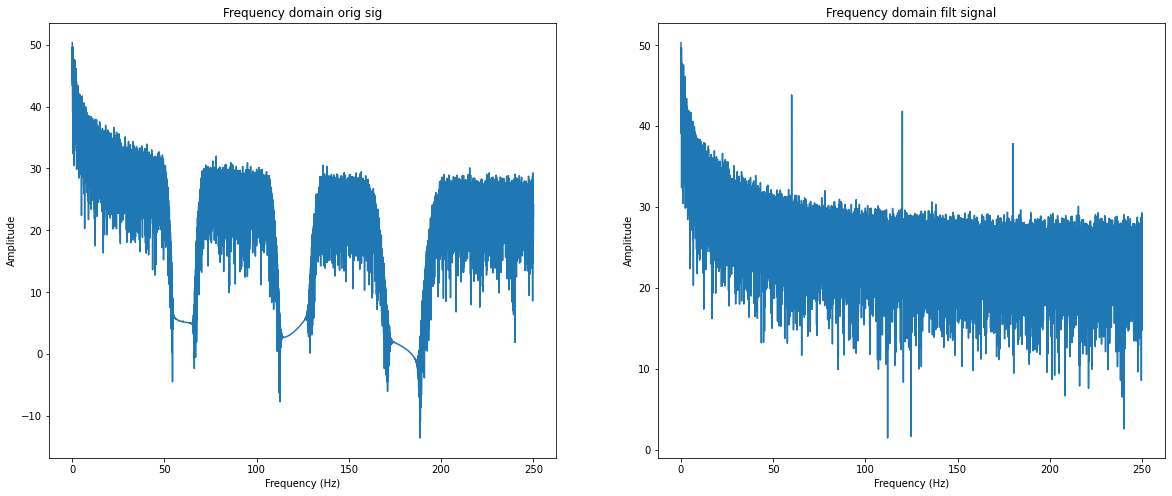

In [ ]:
hz = np.linspace(0,fs/2,int(np.floor(len(t)/2))+1)
fig,[ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
amp = 2*np.abs(scipy.fftpack.fft(x2[:,1], axis=0)/120)
ax1.plot(hz,10*np.log10(amp[0:len(hz)]))
ax1.set_title('Frequency domain orig sig')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
# ax.set_xlim([0,50])

amp = 2*np.abs(scipy.fftpack.fft(x3[:,1], axis=0)/120)
ax2.plot(hz,10*np.log10(amp[0:len(hz)]))
ax2.set_title('Frequency domain filt signal')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

In [ ]:
c0,c1 = bias_fft(xx, (60/500)*np.arange(1,4), 1024)

Text(0, 0.5, 'Amplitude')

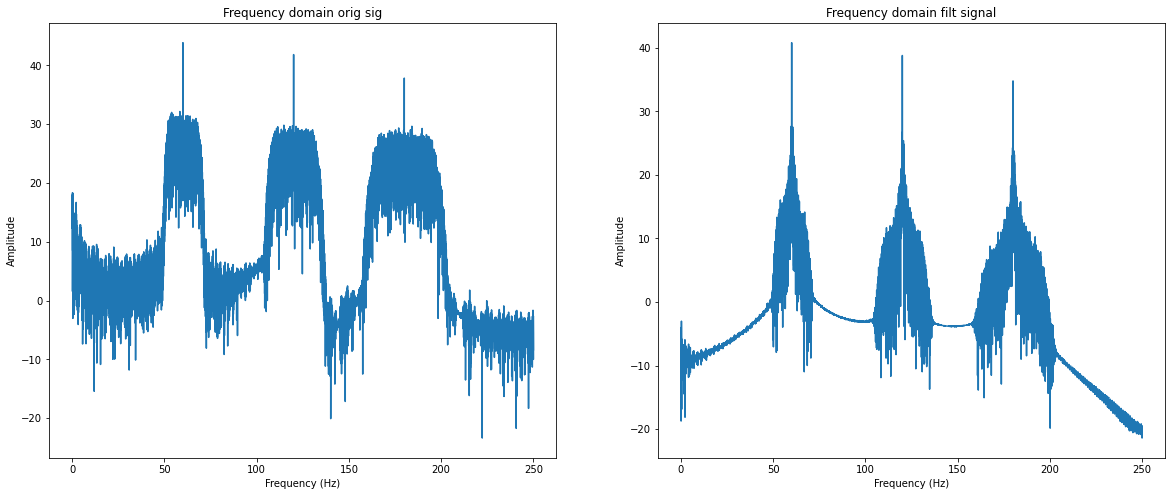

In [ ]:
hz = np.linspace(0,fs/2,int(np.floor(len(t)/2))+1)
fig,[ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
amp = 2*np.abs(scipy.fftpack.fft(xx[:,1], axis=0)/120)
ax1.plot(hz,10*np.log10(amp[0:len(hz)]))
ax1.set_title('Frequency domain orig sig')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
# ax.set_xlim([0,50])

amp = 2*np.abs(scipy.fftpack.fft(x_filt[:,1], axis=0)/120)
ax2.plot(hz,10*np.log10(amp[0:len(hz)]))
ax2.set_title('Frequency domain filt signal')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

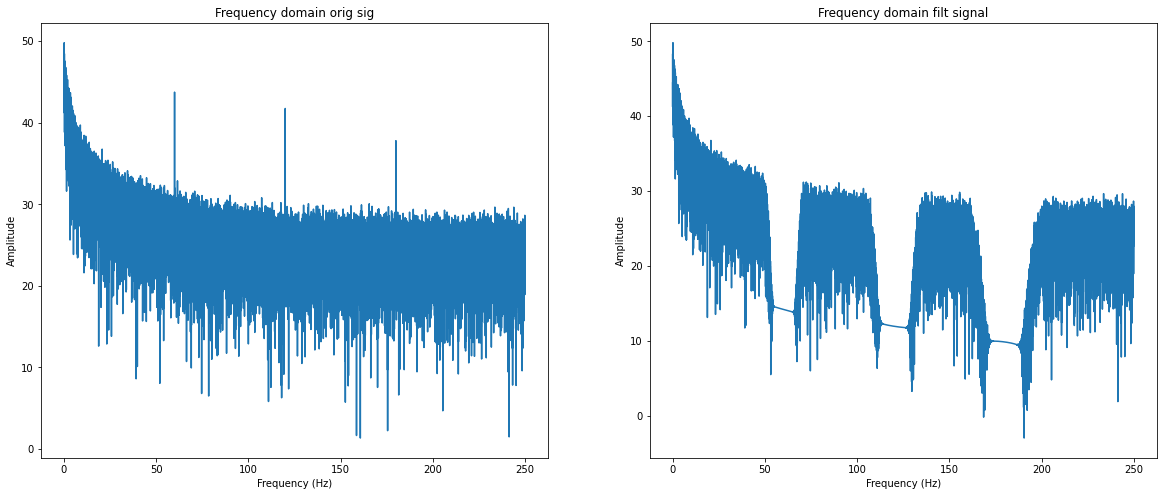

In [ ]:
hz = np.linspace(0,fs/2,int(np.floor(len(t)/2))+1);
fig,[ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
amp = 2*np.abs(scipy.fftpack.fft(x)/120)
ax1.plot(hz,10*np.log10(amp[0:len(hz)]))
ax1.set_title('Frequency domain orig sig')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
# ax.set_xlim([0,50])

amp = 2*np.abs(scipy.fftpack.fft(x3)/120)
ax2.plot(hz,10*np.log10(amp[0:len(hz)]))
ax2.set_title('Frequency domain filt signal')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

In [ ]:
# Alternative
srate = 500
nHarmonics = 3
fline = 60

lower_trans = .12
upper_trans = .12
filtorder = 16*np.round(srate/(int(nHarmonics/2)*fline-3))+1
kerns = []
for n in np.arange(1, nHarmonics+1):
  f_harmonic = n*fline
  lower_bnd = f_harmonic-3
  upper_bnd = f_harmonic+3
  # filter kernel
  filter_shape = [ 1,1,0,0,1,1 ]
  filter_freqs = [ 0, lower_bnd*(1-lower_trans), lower_bnd, upper_bnd, \
                  upper_bnd+upper_bnd*upper_trans, srate/2 ]
  if n == 1:
    filter_kern = scipy.signal.firls(filtorder,filter_freqs,filter_shape,fs=srate)
  else:
    kern_harm = scipy.signal.firls(filtorder,filter_freqs,filter_shape,fs=srate)
    filter_kern = np.convolve(filter_kern, kern_harm)
  # kern_harm = scipy.signal.firls(filtorder,filter_freqs,filter_shape,fs=srate)
  # kerns.append(kern_harm)

Text(0.5, 1.0, 'Filter kernel (firls)')

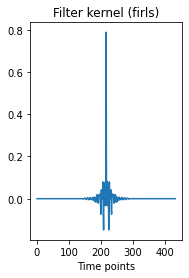

In [ ]:
plt.subplot(121)
plt.plot(filter_kern)
plt.xlabel('Time points')
plt.title('Filter kernel (firls)')

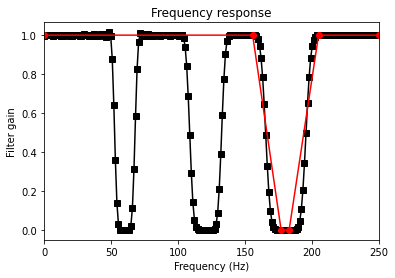

In [ ]:
hz = np.linspace(0,srate/2,int(np.floor(len(filter_kern)/2)+1))
filterpow = np.abs(scipy.fftpack.fft(filter_kern))**2
plt.plot(hz,filterpow[:len(hz)],'ks-')
plt.plot(filter_freqs,filter_shape,'ro-')
plt.xlim([0,250])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.title('Frequency response')
plt.show()

In [ ]:
kerns[0]

array([-8.72581792e-04, -1.68538324e-03, -1.68461245e-03, -6.14506382e-04,
        1.12841435e-03,  2.59845264e-03,  2.80676624e-03,  1.36462141e-03,
       -1.14729228e-03, -3.37992805e-03, -3.94757941e-03, -2.29093137e-03,
        8.69493090e-04,  3.83088743e-03,  4.85021928e-03,  3.19832456e-03,
       -3.27043770e-04, -3.79041958e-03, -5.22389228e-03, -3.79769934e-03,
       -3.31878681e-04,  3.18715697e-03,  4.80103655e-03,  3.74329567e-03,
        8.42308345e-04, -2.07973729e-03, -3.40134032e-03, -2.69236499e-03,
       -8.50532523e-04,  6.74450409e-04,  9.88899801e-04,  3.77478134e-04,
       -3.04974018e-05,  6.87870711e-04,  2.29149549e-03,  3.32264649e-03,
        2.14641275e-03, -1.57747741e-03, -6.10999276e-03, -8.32951607e-03,
       -5.72096261e-03,  1.54832200e-03,  9.98439063e-03,  1.43422812e-02,
        1.07865024e-02, -2.25375619e-04, -1.33474624e-02, -2.08548077e-02,
       -1.71416123e-02, -2.61022215e-03,  1.56386378e-02,  2.72133599e-02,
        2.43478282e-02,  

## Test 2nd algorithm


In [19]:
import numpy as np 
import scipy.signal
import scipy.io as sio
fs = 500;
n = 120*fs; #2-min sequence	
t = np.arange(n)/fs;
# matdat  = sio.loadmat('x_mat2.mat')
nchannels =10;
randn = np.random.randn(n, nchannels)
s = scipy.signal.lfilter([1],[1,-0.99],100*randn,axis=0); #1/f PSD
randn = np.random.randn(n)
fline = 2*np.pi*(60+np.random.randn()) #ramdom interference frequency
p = 90*np.sin(fline*t+randn) + 90*np.sin(2*fline*t+randn)+90*np.sin(3*fline*t+randn); # interference	
p = p.reshape(len(p),1)
x = s + p;
# x = matdat['x']

In [20]:
x.shape

(60000, 10)

In [21]:
y2 = cleanline(x, fs, bandwidth=4)

[60, 120, 180]


<ipython-input-13-edce97497b05>:68: ComplexWarning: Casting complex values to real discards the imaginary part
  datafit[indx, :] = datafitwin
<ipython-input-13-edce97497b05>:68: ComplexWarning: Casting complex values to real discards the imaginary part
  datafit[indx, :] = datafitwin
<ipython-input-13-edce97497b05>:65: ComplexWarning: Casting complex values to real discards the imaginary part
  datafitwin[0:Noverlap,:] = np.multiply(smooth,datafitwin[0:Noverlap,:]) \
<ipython-input-13-edce97497b05>:65: ComplexWarning: Casting complex values to real discards the imaginary part
  datafitwin[0:Noverlap,:] = np.multiply(smooth,datafitwin[0:Noverlap,:]) \


In [22]:
y2.shape

(60000, 10)

In [23]:
y1 = zapline(x, 60/500, 500, filt=1)

caca
2
3


In [24]:
y3 = removePLI(x[:,0].T, fs, 3, [100,0.01,4], [0.1,2,5], 2);

[ 1.          0.73032807  0.06675817 -0.63281734]


## Metrics based on diff with ground truth

In [26]:
from sklearn.metrics import mean_squared_error
def compute_diff(y_true,y_pred,weightage=[0.33,0.33,0.33]):
    ## Time domain similarity
    time_sim = abs(np.sum(y_true - y_pred))

    ## Freq domain similarity
    ref_freq = np.abs(scipy.fftpack.fft(y_true))/len(y_true)
    inp_freq = np.abs(scipy.fftpack.fft(y_pred))/len(y_pred)
    freq_sim = abs(np.sum(ref_freq - inp_freq))

    ## Power similarity
    ref_power = np.sum(y_true**2)
    inp_power = np.sum(y_pred**2)
    power_diff = abs(ref_power-inp_power)

    return np.array([time_sim, freq_sim, power_diff])

In [28]:
# Calculating metric in time/freq/power domain.
# The function calculates diff between signal and a ground truth 's'.
# The smallest the print output, the better
print('Cleanline results:')
diff_cleanline = compute_diff(s[:,0],y2[:,0])/compute_diff(s[:,0],x[:,0])
print(diff_cleanline)

Cleanline results:
[0.97356514 0.93947786 0.64549913]


In [29]:
print('Zapline results:')
diff_Zapline = compute_diff(s[:,0].T,y1[:,0])/compute_diff(s[:,0],x[:,0])
print(diff_Zapline)

Zapline results:
[1.05659903 0.11508022 0.06013977]


In [30]:
print('PLI Removal results:')
diff_PLI = compute_diff(s[:,0].T,y3)/compute_diff(s[:,0],x[:,0])
print(diff_PLI)

PLI Removal results:
[769.76771592   1.00927576   1.20287757]


The best time performance is from Cleanline but Zapline has way better results in freq and power domain

## Time plot comparison

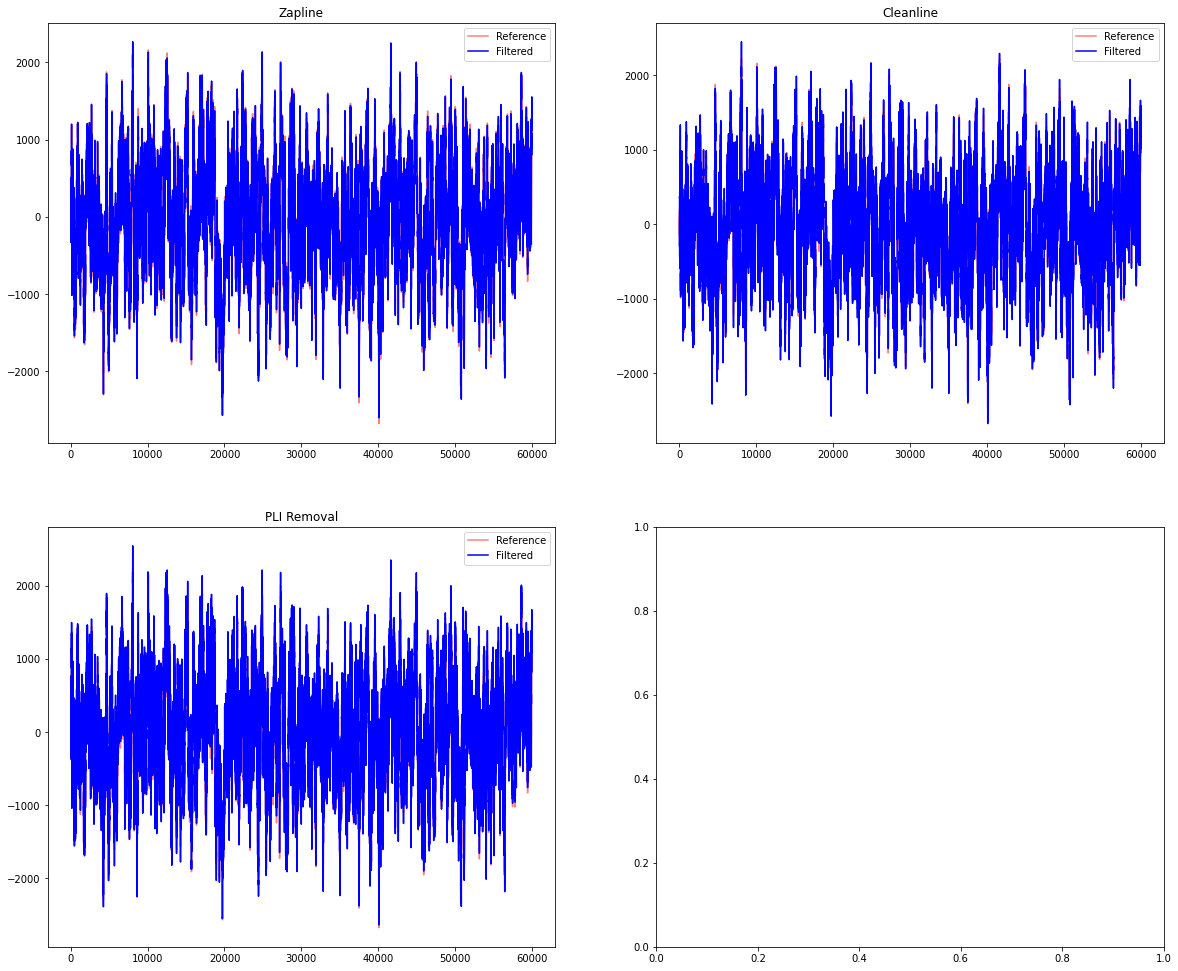

In [36]:
# Comparison against ground truth
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 17))
axs[0,0].plot(s[:,0], 'r', alpha=0.5, label='Reference')
axs[0,0].plot(y1[:,0], 'b', label='Filtered')
axs[0,0].set_title('Zapline')
axs[0,0].legend()

axs[0,1].plot(s[:,0], 'r', alpha=0.5, label='Reference')
axs[0,1].plot(y2[:,0], 'b', label='Filtered')
axs[0,1].set_title('Cleanline')
axs[0,1].legend()

axs[1,0].plot(s[:,0], 'r', alpha=0.5, label='Reference')
axs[1,0].plot(y3, 'b', label='Filtered')
axs[1,0].set_title('PLI Removal')
axs[1,0].legend()

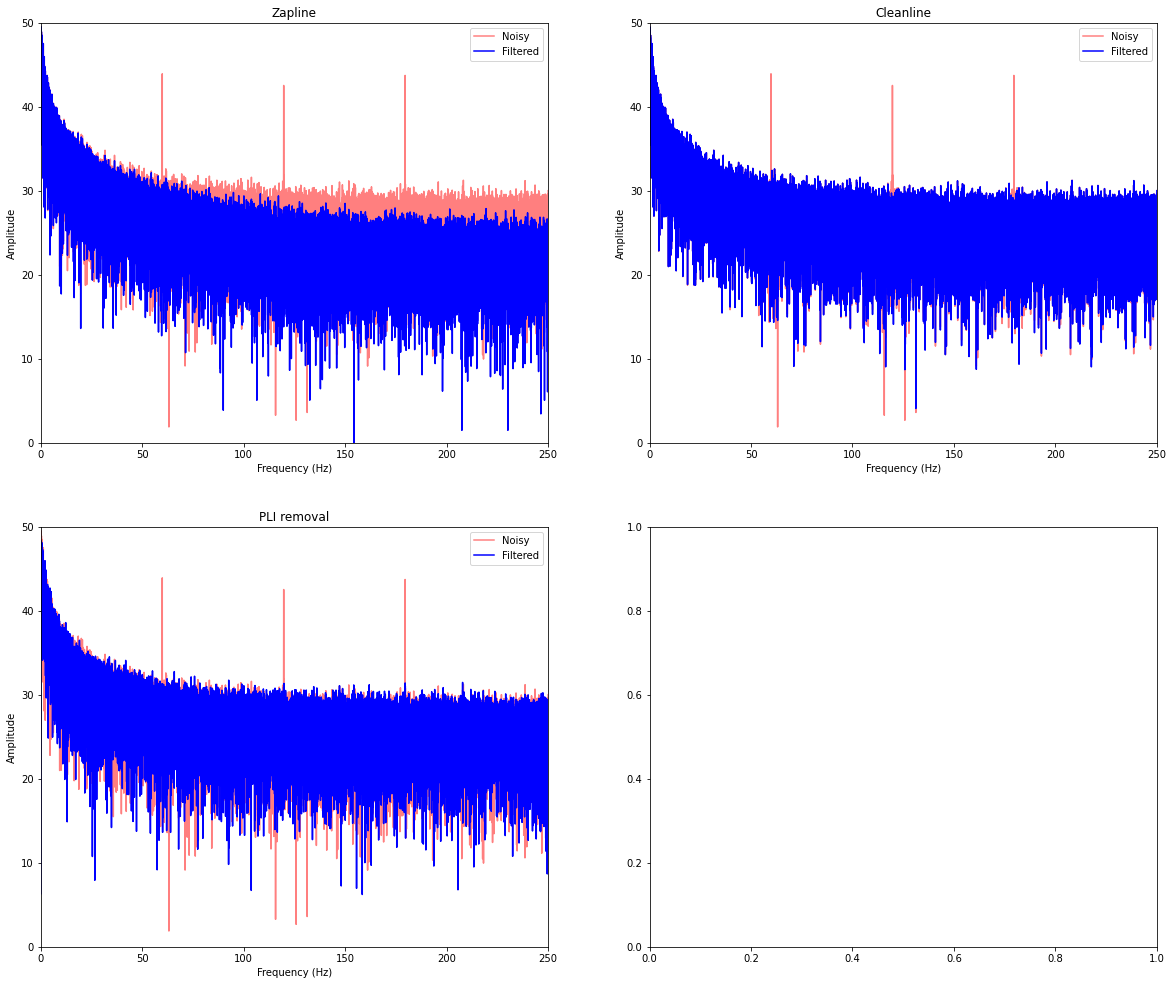

In [38]:
# With original noisy signal
import numpy as np
import scipy.signal
import scipy.fftpack
import matplotlib.pyplot as plt
hz = np.linspace(0,fs/2,int(np.floor(len(t)/2))+1)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 17))
amp = 2*np.abs(scipy.fftpack.fft(x[:,1], axis=0)/120)
axs[0,0].plot(hz,10*np.log10(amp[0:len(hz)]), 'r', alpha=0.5, label='Noisy')
amp1 = 2*np.abs(scipy.fftpack.fft(y1[:,1], axis=0)/120)
axs[0,0].plot(hz[0:],10*np.log10(amp1[0:len(hz)]), 'b', label='Filtered')
axs[0,0].set_title('Zapline')
axs[0,0].set_xlabel('Frequency (Hz)')
axs[0,0].set_ylabel('Amplitude')
axs[0,0].set_xlim([0,250])
axs[0,0].set_ylim([0,50])
axs[0,0].legend()

amp = 2*np.abs(scipy.fftpack.fft(x[:,1], axis=0)/120)
axs[0,1].plot(hz,10*np.log10(amp[0:len(hz)]), 'r', alpha=0.5, label='Noisy')
amp1 = 2*np.abs(scipy.fftpack.fft(y2[:,1], axis=0)/120)
axs[0,1].plot(hz[0:],10*np.log10(amp1[0:len(hz)]), 'b', label='Filtered')
axs[0,1].set_title('Cleanline')
axs[0,1].set_xlabel('Frequency (Hz)')
axs[0,1].set_ylabel('Amplitude')
axs[0,1].set_xlim([0,250])
axs[0,1].set_ylim([0,50])
axs[0,1].legend()

amp = 2*np.abs(scipy.fftpack.fft(x[:,1], axis=0)/120)
axs[1,0].plot(hz,10*np.log10(amp[0:len(hz)]), 'r', alpha=0.5, label='Noisy')
amp1 = 2*np.abs(scipy.fftpack.fft(y3, axis=0)/120)
axs[1,0].plot(hz[0:],10*np.log10(amp1[0:len(hz)]), 'b', label='Filtered')
axs[1,0].set_title('PLI removal')
axs[1,0].set_xlabel('Frequency (Hz)')
axs[1,0].set_ylabel('Amplitude')
axs[1,0].set_xlim([0,250])
axs[1,0].set_ylim([0,50])
axs[1,0].legend()

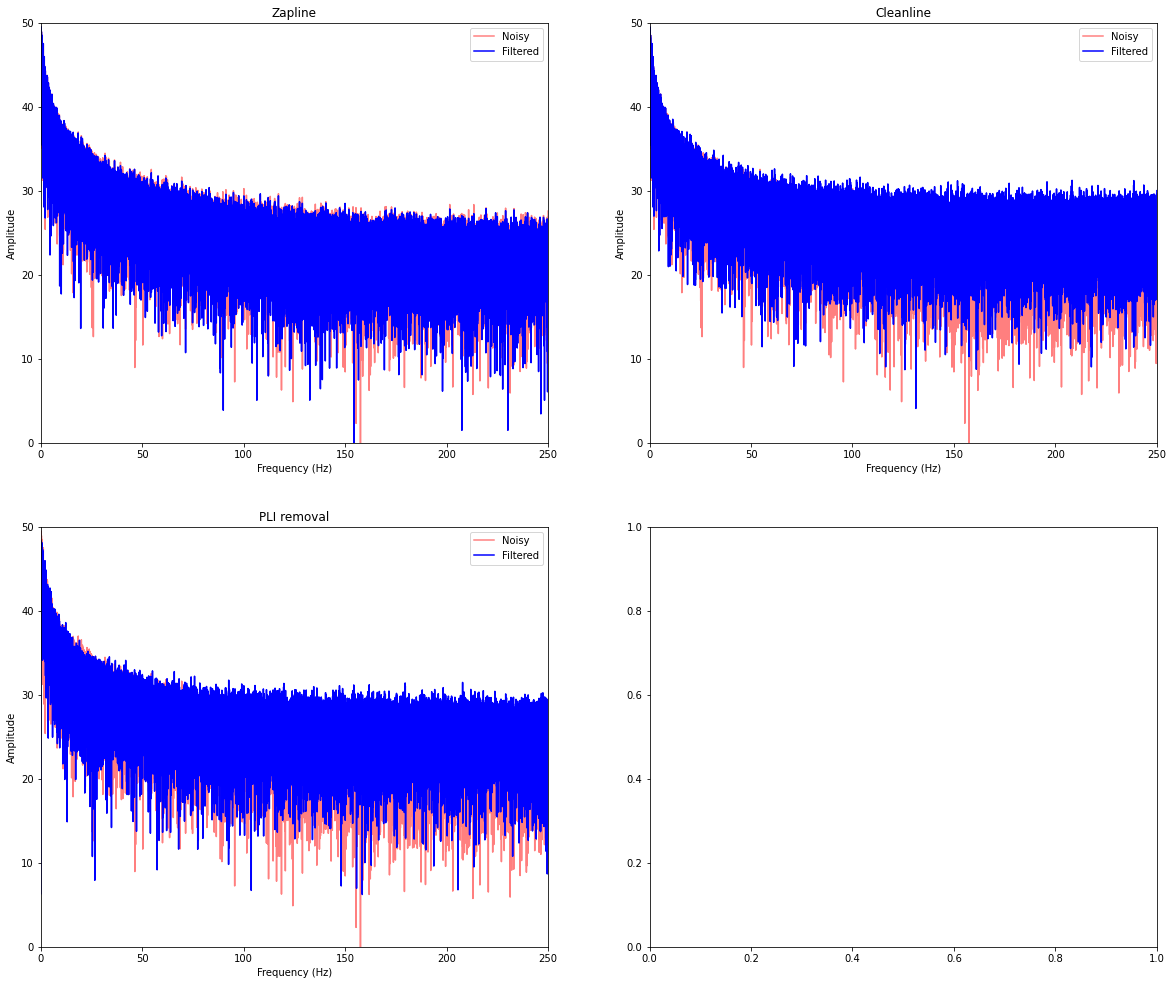

In [39]:
# With ground truth
import numpy as np
import scipy.signal
import scipy.fftpack
import matplotlib.pyplot as plt
hz = np.linspace(0,fs/2,int(np.floor(len(t)/2))+1)
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 17))
amp = 2*np.abs(scipy.fftpack.fft(s[:,1], axis=0)/120)
axs[0,0].plot(hz,10*np.log10(amp[0:len(hz)]), 'r', alpha=0.5, label='Noisy')
amp1 = 2*np.abs(scipy.fftpack.fft(y1[:,1], axis=0)/120)
axs[0,0].plot(hz[0:],10*np.log10(amp1[0:len(hz)]), 'b', label='Filtered')
axs[0,0].set_title('Zapline')
axs[0,0].set_xlabel('Frequency (Hz)')
axs[0,0].set_ylabel('Amplitude')
axs[0,0].set_xlim([0,250])
axs[0,0].set_ylim([0,50])
axs[0,0].legend()

amp = 2*np.abs(scipy.fftpack.fft(s[:,1], axis=0)/120)
axs[0,1].plot(hz,10*np.log10(amp[0:len(hz)]), 'r', alpha=0.5, label='Noisy')
amp1 = 2*np.abs(scipy.fftpack.fft(y2[:,1], axis=0)/120)
axs[0,1].plot(hz[0:],10*np.log10(amp1[0:len(hz)]), 'b', label='Filtered')
axs[0,1].set_title('Cleanline')
axs[0,1].set_xlabel('Frequency (Hz)')
axs[0,1].set_ylabel('Amplitude')
axs[0,1].set_xlim([0,250])
axs[0,1].set_ylim([0,50])
axs[0,1].legend()

amp = 2*np.abs(scipy.fftpack.fft(s[:,1], axis=0)/120)
axs[1,0].plot(hz,10*np.log10(amp[0:len(hz)]), 'r', alpha=0.5, label='Noisy')
amp1 = 2*np.abs(scipy.fftpack.fft(y3, axis=0)/120)
axs[1,0].plot(hz[0:],10*np.log10(amp1[0:len(hz)]), 'b', label='Filtered')
axs[1,0].set_title('PLI removal')
axs[1,0].set_xlabel('Frequency (Hz)')
axs[1,0].set_ylabel('Amplitude')
axs[1,0].set_xlim([0,250])
axs[1,0].set_ylim([0,50])
axs[1,0].legend()

Zapline is the one that improves the best, as it was expected

## Additional tests

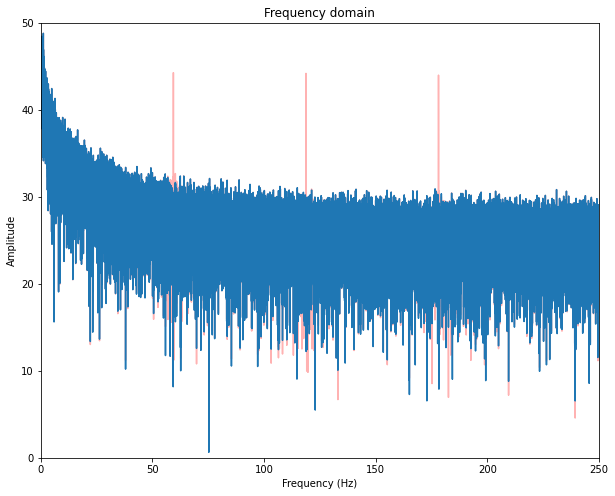

In [ ]:
# With my filter
import numpy as np
import scipy.signal
import scipy.fftpack
import matplotlib.pyplot as plt
hz = np.linspace(0,fs/2,int(np.floor(len(t)/2))+1)
fig,ax1 = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
# True
amp2 = 2*np.abs(scipy.fftpack.fft(x[:,0], axis=0)/120)
ax1.plot(hz,10*np.log10(amp2[0:len(hz)]),'r', alpha=0.3)
# Filtered
amp = 2*np.abs(scipy.fftpack.fft(y2[:,0], axis=0)/120)
ax1.plot(hz[0:],10*np.log10(amp[0:len(hz)]))
ax1.set_title('Frequency domain')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
ax1.set_ylim([0,50])
ax1.set_xlim([0,250])
plt.show()

## Test

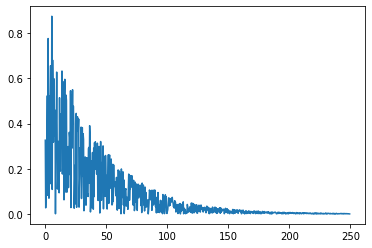

In [ ]:
# Create fake neural data
srate = 500; # sampling rate in Hz
time  = np.arange(-1,2,1/srate)
pnts  = len(time);
hz    = np.linspace(0,srate/2,int(np.floor(len(time)/2))+1);

# generate 1/f amplitude spectrum
ed = 120; # exponential decay parameter
spec = np.multiply(np.random.rand(int(np.floor(pnts/2))-1), np.exp(-(np.arange(int(np.floor(pnts/2))-1))/ed))
plt.plot(hz[0:len(spec)], spec)
spec = np.concatenate((spec, [0], [0], spec[::-1]))

In [ ]:
pnts

1500

In [ ]:
# Fourier coefficients
fc = np.multiply(spec, np.exp(1j*2*np.pi*np.random.rand(spec.size)))
# inverse Fourier transform to create the noise
eeg = np.real(scipy.fftpack.ifft(fc)) * pnts;
fline = 2*np.pi*60
randn = 0.2*np.random.randn(len(eeg))
p = 1*np.sin(fline*time+randn) + 0.7*np.sin(2*fline*time+randn)+0.5*np.sin(3*fline*time+randn); # interference	
eeg_cont = eeg + p;

Text(0, 0.5, 'Amplitude')

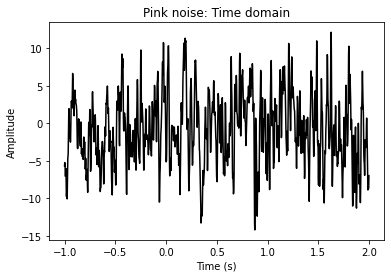

In [ ]:
fig,ax = plt.subplots()
ax.plot(time,eeg,'k')
ax.set_title('Pink noise: Time domain')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')

Text(0, 0.5, 'N per bin')

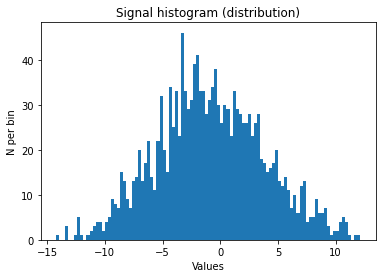

In [ ]:
fig,ax = plt.subplots()
ax.hist(eeg, bins=100)
ax.set_title('Signal histogram (distribution)')
ax.set_xlabel('Values')
ax.set_ylabel('N per bin')

Text(0, 0.5, 'Amplitude')

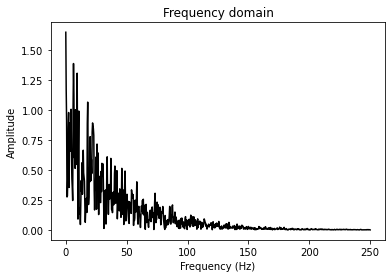

In [ ]:
fig,ax = plt.subplots()
amp = 2*np.abs(scipy.fftpack.fft(eeg)/pnts)
ax.plot(hz,amp[0:len(hz)],'k')
ax.set_title('Frequency domain')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
# ax.set_xlim([0,200])

Text(0, 0.5, 'Amplitude')

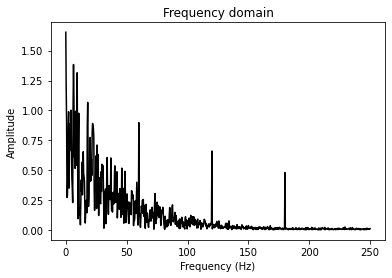

In [ ]:
fig,ax = plt.subplots()
amp = 2*np.abs(scipy.fftpack.fft(eeg_cont)/pnts)
ax.plot(hz,amp[0:len(hz)],'k')
ax.set_title('Frequency domain')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
# ax.set_xlim([0,200])

In [ ]:
np.ones(3)

array([1., 1., 1.])

In [ ]:
# Testing
s_filt = removePLI(eeg_cont, 500, 3, [100,0.01,4], [0.1,2,5], 0.5, 60)

[ 1.          0.72872837  0.06209007 -0.63823477]


In [ ]:
s_filt

array([ 0.        ,  5.06700554,  6.35267635, ..., -2.90183327,
        0.94089423,  3.32769043])

Text(0, 0.5, 'Amplitude')

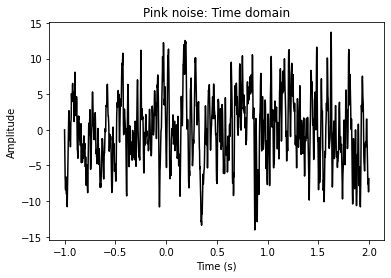

In [ ]:
fig,ax = plt.subplots()
ax.plot(time,s_filt,'k')
ax.set_title('Pink noise: Time domain')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

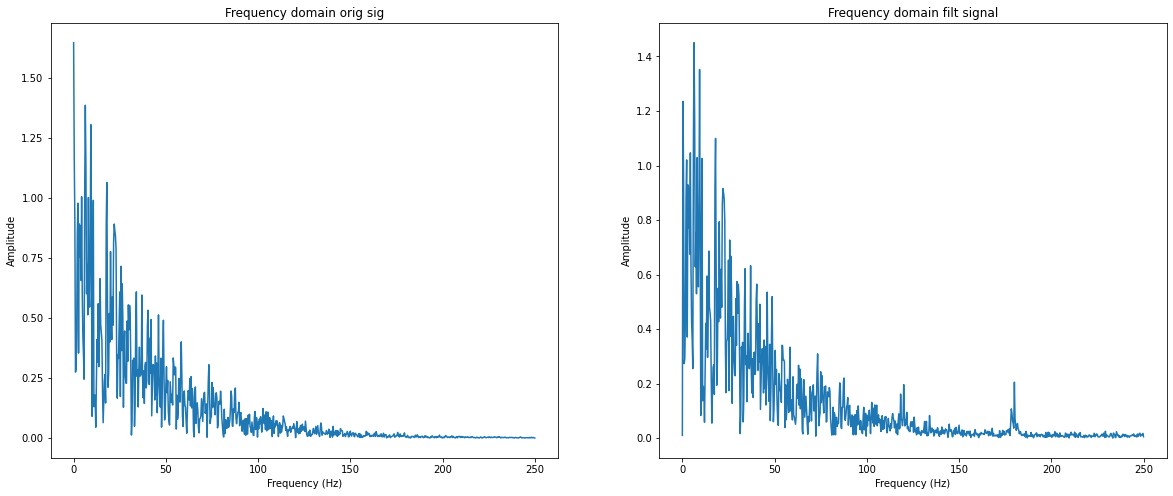

In [ ]:
fig,[ax1,ax2] = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
amp = 2*np.abs(scipy.fftpack.fft(eeg)/pnts)
ax1.plot(hz,(amp[0:len(hz)]))
ax1.set_title('Frequency domain orig sig')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')
# ax.set_xlim([0,50])

amp = 2*np.abs(scipy.fftpack.fft(s_filt)/pnts)
ax2.plot(hz,(amp[0:len(hz)]))
ax2.set_title('Frequency domain filt signal')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

Text(0, 0.5, 'Amplitude')

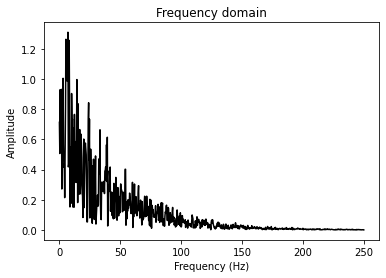

In [ ]:
fig,ax = plt.subplots()
amp = 2*np.abs(scipy.fftpack.fft(eeg)/pnts)
ax.plot(hz,amp[0:len(hz)],'k')
ax.set_title('Frequency domain')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Amplitude')
# ax.set_xlim([0,200])